In [ ]:
import os
import numpy as np


def load_collection(path, verbose=True):
    """
    Load collection of document from disk
    
    Arguments
    ---------
    path : str
        Path to folder with txt files
    
    verbose : bool
        If True then print additional info 
    
    Return
    ------
    collection : dict (key=file name (str), value=text collection (str))
    """
    collection = dict()
    for file_name in os.listdir(path):
        with open(path + '/' + file_name, 'r') as f_input:
            new_document = f_input.read()
            collection[file_name] = new_document
    
    if verbose:
        print('Total number of documents: {}'.format(len(collection)))
        print()
        print('Some document examples: ')
        document_examples = list(collection.values())[:5]
        document_examples = [example[:100] + '...' for example in document_examples]
        for example in document_examples:
            print('\t' + example)
        print()
        print('Some file names examples: ')
        file_name_examples = list(collection.keys())[:5]
        for example in file_name_examples:
            print('\t' + example)
            

    return collection


def load_parallel_documents_info(path, verbose=True):
    """
    Read files with information about parallel documents
    
    Arguments
    ---------
    path : str
        Path to file
        
    Return
    ------
    parallel_info : dict (key=file name of one language(str),
                          value=file name of other language (str))
    """
    parallel_info = dict()
    with open(path, 'r') as f:
        for line in f:
            one_language_doc, other_language_doc = line.split()
            parallel_info[one_language_doc.strip()] = other_language_doc.strip()
    if verbose:
        print('Total number of pairs: {}'.format(len(parallel_info)))
    return parallel_info


def write_vw_lab4(output_path,
                  en_cleaned_collection,
                  ru_cleaned_collection,
                  es_cleaned_collection,
                  en_ru_parallel_docs,
                  en_es_parallel_docs,
                  use_parallel_info):
    """
    Write collection on a disk in vowpal wabbit format.
    
    Arguments
    ---------
    output_path : str
        Path of output file
    
    en_cleaned_collection : dict (key=file name (str), value=text document (str))
        Collection of cleaned russian texts
    
    ru_cleaned_collection : dict (key=file name (str), value=text document (str))
        Collection of cleaned russian texts
        
    es_cleaned_collection : dict (key=file name (str), value=text document (str))
        Collection of cleaned spanish texts
        
    en_ru_parallel_docs : dict (key=file name of one language(str),
                                value=file name of other language (str))
        Parallel info for english and russian
        
    en_es_parallel_docs :  dict (key=file name of one language(str),
                                 value=file name of other language (str))
        Parallel info for english and spanish
    
    use_parallel_info : bool
        If True then parallel docs info is used to costruct vowpal wabbit file.
    """    
    with open(output_path, 'w') as f_output:
        # en documents and parallel info
        for en_file_name, en_content in en_cleaned_collection.items():
            new_document = '{} |@english {} '.format(en_file_name, en_content)
            
            if use_parallel_info:
                if en_file_name in en_ru_parallel_docs:
                    ru_content = ru_cleaned_collection[en_ru_parallel_docs[en_file_name]]
                    new_document += '|@russian {} '.format(ru_content)

                if en_file_name in en_es_parallel_docs:
                    es_content = es_cleaned_collection[en_es_parallel_docs[en_file_name]]
                    new_document += '|@spanish {}'.format(es_content)
            
            f_output.write(new_document + '\n')
        
        for ru_file_name, ru_content in ru_cleaned_collection.items():
            if use_parallel_info:
                if ru_file_name in en_ru_parallel_docs.values():
                    continue
            new_document = '{} |@russian {}'.format(ru_file_name, ru_content)
            f_output.write(new_document + '\n')
        
        for es_file_name, es_content in es_cleaned_collection.items():
            if use_parallel_info:
                if es_file_name in en_es_parallel_docs.values():
                    continue
            new_document = '{} |@spanish {}'.format(es_file_name, es_content)
            f_output.write(new_document + '\n')        
        

def get_indexes_of_relevant_documents(theta, parallel_docs, metric='cosine'):
    """
    Calculate position in search output
    for each translation document in parallel_docs.  

    Parameters
    ----------
    theta : pandas.DataFrame of shape (n_topics, n_documents)
    
    parallel_docs : dict (key=file name of one language(str),
                          value=file name of other language (str))
        Parallel info for two languages
    
    metric : str, cosine or dot
        Metric for neighbors calculating

    Return
    -------
    result_index : list of int
        Positions of each document in search output

    docs_pair : list of (str, str)
        Sequence of docs pairs from parallel_docs.
        docs_pair[i] corresponds to result_index[i]. 
    """
    if metric not in {'cosine', 'dot'}:
        raise TypeError('metric should be cosine or dot')
    
    theta_T = theta.T
    embeddigns_norms = (theta_T ** 2).sum(axis=1) ** 0.5
        
    one_language_relevant_docs, _ = zip(*parallel_docs.items())
    one_language_relevant_docs = list(one_language_relevant_docs)
    one_language_relevant_embeddings = (
        theta_T
        .loc[one_language_relevant_docs]
    )
    one_language_relevant_norms = (
        embeddigns_norms
        .loc[one_language_relevant_docs]
    )
    
    second_language_example = next(iter(parallel_docs.values()))
    second_language_docs = [
        document
        for document in theta_T.index
        if document[:2] == second_language_example[:2]
    ]
    second_language_embeddings = theta_T.loc[second_language_docs]
    second_language_norms = embeddigns_norms.loc[second_language_docs]
    
    similarity_matrix = (
        one_language_relevant_embeddings
        .dot(second_language_embeddings.T)
    )
    
    if metric == 'cosine':
        similarity_matrix = similarity_matrix.div(one_language_relevant_norms, axis='index')
        similarity_matrix = similarity_matrix.div(second_language_norms, axis='columns')
    
    similarity_matrix_array = similarity_matrix.values
    estimations = similarity_matrix_array.argsort(axis=1)[:, ::-1]
    second_lang_doc_to_number = dict(zip(similarity_matrix.columns,
                                         range(len(similarity_matrix.columns))))
    
    result_index = []
    docs_pair = []
    
    for i, one_document in enumerate(similarity_matrix.index):
        if parallel_docs[one_document] not in similarity_matrix.columns:
            continue
        doc_index = second_lang_doc_to_number[
            parallel_docs[one_document]
        ]
        index_in_output = np.where(estimations[i] == doc_index)[0]
        result_index.append(index_in_output[0])
        docs_pair.append((one_document, parallel_docs[one_document]))
    return result_index, docs_pair

#### Импорт важных библиотек

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 8.2MB 8.0MB/s 


In [ ]:
!pip install bigartm10

     |████████████████████████████████| 2.0MB 5.7MB/s 


In [ ]:
# считывание
import os
import glob
import json

# предобработка
import pymorphy2
import nltk
import re

# тематическое моделирование
import artm

# change log style for artm
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline

# прочее 
import numpy as np

#### Несколько важных промежуточных функций

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RU_DATA_PATH = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/ru'
ru_collection = load_collection(RU_DATA_PATH, verbose=True)

Total number of documents: 2731

Some document examples: 
	Нет ничего больше или старше, чем вселенная. Сегодня я хочу обсудить следующие вопросы: Во-первых, к...
	Я нейрохирург. И, как и многие мои коллеги, я каждый день сталкиваюсь с людскими трагедиями. Я поним...
	Месячные. Кровь. Менструация. Неприлично. Секрет. Спрятать. Почему?
Естественный биологический проце...
	Адам Окельфорд: Я обещаю поменьше говорить и предоставить возможность Дереку больше играть. Думаю, н...
	Как художнику для меня очень важна взаимосвязь. В своих работах я пытаюсь показать, что люди неотдел...

Some file names examples: 
	ru_2654
	ru_2656
	ru_2657
	ru_2658
	ru_2659


In [ ]:
ru_collection["ru_2654"]

'Нет ничего больше или старше, чем вселенная. Сегодня я хочу обсудить следующие вопросы: Во-первых, каково происхождение человека? Каково происхождение вселенной? Одни ли мы во вселенной? Существует ли жизнь на других планетах? Какова будущая судьба человечества?\nДо 20-х годов ХХ столетия считалось, что вселенная является по большому счету неподвижной и неизменной во времени. Затем было установлено, что вселенная расширяется. Что далекие галактики удаляются от нас. Это значит, что когда-то в прошлом они были ближе друг к другу. Из этого можно сделать вывод, что когда-то все эти галактики, должно быть, находились все в одной точке — около 15 миллиардов лет назад. Мы называем это Большим взрывом, началом вселенной.\nНо существовало ли что-нибудь до Большого взрыва? Если нет, то как была создана вселенная? Почему именно такая вселенная образовалась в результате Большого взрыва? Раньше мы считали, что теория вселенной может быть разделена на две части. Первая часть включала законы, такие 

In [ ]:
list(ru_collection.values())[:3]

['Нет ничего больше или старше, чем вселенная. Сегодня я хочу обсудить следующие вопросы: Во-первых, каково происхождение человека? Каково происхождение вселенной? Одни ли мы во вселенной? Существует ли жизнь на других планетах? Какова будущая судьба человечества?\nДо 20-х годов ХХ столетия считалось, что вселенная является по большому счету неподвижной и неизменной во времени. Затем было установлено, что вселенная расширяется. Что далекие галактики удаляются от нас. Это значит, что когда-то в прошлом они были ближе друг к другу. Из этого можно сделать вывод, что когда-то все эти галактики, должно быть, находились все в одной точке — около 15 миллиардов лет назад. Мы называем это Большим взрывом, началом вселенной.\nНо существовало ли что-нибудь до Большого взрыва? Если нет, то как была создана вселенная? Почему именно такая вселенная образовалась в результате Большого взрыва? Раньше мы считали, что теория вселенной может быть разделена на две части. Первая часть включала законы, такие

In [ ]:
import re
import nltk
nltk.download("stopwords")
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import spacy



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
morph = pymorphy2.MorphAnalyzer()
#morph.parse('')[0].normal_form
#nlp_ru = spacy.load('ru2', disable=['parser', 'ner'])
#tokenizer = RegexpTokenizer(r'[a-zA-Zα-ωΑ-Ω]+\-?[a-zA-Zα-ωΑ-Ω]+')
tokenizer_ru = RegexpTokenizer(r'[а-яА-Я]+')
stopwords_ru = stopwords.words('russian')+["аплодисменты","спасибо","x","xx","который","нный"]

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [ ]:
def preproccesing_ru(text):
  l_c = text.lower()
  s1 = [word for word in tokenizer_ru.tokenize(l_c)]
  s2 = [morph.parse(i)[0].normal_form for i in s1]
  s3 = ' '.join([word for word in s2  if word not in stopwords_ru and len(word)>3])
  return s3


In [ ]:
s = preproccesing_ru(ru_collection["ru_2654"])
s

'большой старший вселенная сегодня хотеть обсудить следующий вопрос первый каков происхождение человек каков происхождение вселенная вселенная существовать жизнь планета каков будущий судьба человечество столетие считаться вселенная являться большой счёт неподвижный неизменный время затем установить вселенная расширяться далёкий галактика удаляться значит прошлый близкий друг друг сделать вывод галактика должный находиться точка около миллиард назад называть больший взрыв начало вселенная существовать нибыть большой взрыв создать вселенная почему именно вселенная образоваться результат большой взрыв ранний считать теория вселенная мочь разделить часть первый часть включать закон уравнение максвелл общий теория относительность объяснять эволюция вселенная брать основа повсеместный состояние определённый момент время второй часть достаточно очевидный описывать начальный состояние вселенная первый часть продвинуться впереть далее знать очень многое закон эволюция практически весь условие 

In [ ]:
preproccesing_ru("который")

''

In [ ]:
dictionary_ru = dict()
for key,value in ru_collection.items():
  dictionary_ru[key] =  preproccesing_ru(value)

Проанализируйте несколько предобработанных документов. Отметьте, какие неточности работы алгоритмов вы заметили, и как они могут повлиять на итоговую модель.

In [ ]:
list(dictionary_ru.values())[:3]

['большой старший вселенная сегодня хотеть обсудить следующий вопрос первый каков происхождение человек каков происхождение вселенная вселенная существовать жизнь планета каков будущий судьба человечество столетие считаться вселенная являться большой счёт неподвижный неизменный время затем установить вселенная расширяться далёкий галактика удаляться значит прошлый близкий друг друг сделать вывод галактика должный находиться точка около миллиард назад называть больший взрыв начало вселенная существовать нибыть большой взрыв создать вселенная почему именно вселенная образоваться результат большой взрыв ранний считать теория вселенная мочь разделить часть первый часть включать закон уравнение максвелл общий теория относительность объяснять эволюция вселенная брать основа повсеместный состояние определённый момент время второй часть достаточно очевидный описывать начальный состояние вселенная первый часть продвинуться впереть далее знать очень многое закон эволюция практически весь условие

In [ ]:
EN_DATA_PATH = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/en'
en_collection = load_collection(EN_DATA_PATH, verbose=True)

Total number of documents: 2856

Some document examples: 
	Growth is not dead.
(Applause)
Let's start the story 120 years ago, when American factories began to...
	I'm the weekly tech critic for the New York Times. I review gadgets and stuff. And mostly what good ...
	I want to talk to you today about something the open-source programming world can teach democracy, b...
	I have to tell you, it's more than a little intimidating being up here, an old American guy trying t...
	I'm going to speak about a tiny, little idea. And this is about shifting baseline. And because the i...

Some file names examples: 
	en_2685
	en_2686
	en_2688
	en_2687
	en_2689


In [ ]:
list(en_collection.values())[:1]

['Growth is not dead.\n(Applause)\nLet\'s start the story 120 years ago, when American factories began to electrify their operations, igniting the Second Industrial Revolution. The amazing thing is that productivity did not increase in those factories for 30 years. Thirty years. That\'s long enough for a generation of managers to retire. You see, the first wave of managers simply replaced their steam engines with electric motors, but they didn\'t redesign the factories to take advantage of electricity\'s flexibility. It fell to the next generation to invent new work processes, and then productivity soared, often doubling or even tripling in those factories.\nElectricity is an example of a general purpose technology, like the steam engine before it. General purpose technologies drive most economic growth, because they unleash cascades of complementary innovations, like lightbulbs and, yes, factory redesign. Is there a general purpose technology of our era? Sure. It\'s the computer. But 

In [ ]:
from nltk import WordNetLemmatizer
morph = pymorphy2.MorphAnalyzer()
#morph.parse('')[0].normal_form
#nlp_ru = spacy.load('ru2', disable=['parser', 'ner'])
tokenizer_en = RegexpTokenizer(r'[a-zA-Z]+')
stopwords_en = stopwords.words('english')+["applause","thank"]
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def preproccesing_en(text):
  res = text[:text.index("TED.com translations are made")] 
  l_c = res.lower()
  s1 = [word for word in tokenizer_en.tokenize(l_c)]
  s2 = [lemmatizer.lemmatize(i) for i in s1]
  s3 = ' '.join([word for word in s2  if word not in stopwords_en and len(word)>3])

  return s3

In [ ]:
en_collection["en_2685"]

'Growth is not dead.\n(Applause)\nLet\'s start the story 120 years ago, when American factories began to electrify their operations, igniting the Second Industrial Revolution. The amazing thing is that productivity did not increase in those factories for 30 years. Thirty years. That\'s long enough for a generation of managers to retire. You see, the first wave of managers simply replaced their steam engines with electric motors, but they didn\'t redesign the factories to take advantage of electricity\'s flexibility. It fell to the next generation to invent new work processes, and then productivity soared, often doubling or even tripling in those factories.\nElectricity is an example of a general purpose technology, like the steam engine before it. General purpose technologies drive most economic growth, because they unleash cascades of complementary innovations, like lightbulbs and, yes, factory redesign. Is there a general purpose technology of our era? Sure. It\'s the computer. But t

In [ ]:
s = preproccesing_en(en_collection["en_2685"])
s

'growth dead start story year american factory began electrify operation igniting second industrial revolution amazing thing productivity increase factory year thirty year long enough generation manager retire first wave manager simply replaced steam engine electric motor redesign factory take advantage electricity flexibility fell next generation invent work process productivity soared often doubling even tripling factory electricity example general purpose technology like steam engine general purpose technology drive economic growth unleash cascade complementary innovation like lightbulb factory redesign general purpose technology sure computer technology alone enough technology destiny shape destiny earlier generation manager needed redesign factory going need reinvent organization even whole economic system well moment productivity actually right become decoupled income typical worker stagnating trouble sometimes misdiagnosed innovation actually growing pain andrew mcafee call mach

In [ ]:
dictionary_en = dict()
for key,value in en_collection.items():
  dictionary_en[key] =  preproccesing_en(value)

In [ ]:
ES_DATA_PATH = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/es'
es_collection = load_collection(ES_DATA_PATH, verbose=True)

Total number of documents: 2809

Some document examples: 
	Les mostraré algo.
(Video) Niña: Eso es un gato sentado en una cama. El niño está acariciando al ele...
	La electricidad que alimenta las luces en este teatro ha sido generada hace unos momentos. Porque co...
	Dirijo un estudio de diseño en Nueva York. Cada siete años cierro durante un año para dedicarme a al...
	Aquí algunas fotos de mi voluntariado en un orfanato camboyano en 2006. Cuando se tomaron estas foto...
	Señoras y señores, en TED hablamos mucho sobre liderazgo y como hacer un movimiento. Veamos ocurrir ...

Some file names examples: 
	es_2671
	es_2672
	es_2673
	es_2674
	es_2675


In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
morph = pymorphy2.MorphAnalyzer()
tokenizer_sp = RegexpTokenizer(r'[a-zA-Z]+')
stopwords_sp = stopwords.words('spanish')+["aplausos","gracias"]



/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [ ]:
def preproccesing_sp(text):
  res = text[:text.index("TED.com translations are made")]
  l_c = res.lower()
  s1 = [word for word in tokenizer_sp.tokenize(l_c)]
  s2 = [stemmer.stem(i) for i in s1]
  s3 = ' '.join([word for word in s2  if word not in stopwords_sp and len(word)>3])

  return s3

In [ ]:
s = preproccesing_sp(es_collection["es_2671"])
s

'mostr vide sent acarici elef person grand describ seri falt much aprend sobr mund expert import entend tecnol nuestr socied avanz nunc envi person nuestr habl personaliz radi reproduc gust embarg nuestr quin comput avanz tien problem aspect darl report nuestr ltim avanc visi artificial tecnolog potencial revolucionari cienci computaci ciert invent conduc visi inteligent realment pued distingu bols arrug papel camin pued mism evit fabul much megap devolv vist cieg dron pued sobr grand superfici tierr tien tecnolog visi suficient ayud monitor cambi bosqu tropical segur part alert cuand ahog piscin vide volv part integral global gener ritm much mayor cualqui human equip human podr contribu nuestr softwar avanz tien problem entend gestion enorm conten palabr colect socied cieg porqu nuestr quin inteligent cieg pregunt pued convirt matric bidimensional conoc pixel mism tien signific igual mism escuch fotograf mism viend realment entend hech madr naturalez millon ardu trabaj logr tare much 

In [ ]:
dictionary_sp = dict()
for key,value in es_collection.items():
  dictionary_sp[key] =  preproccesing_sp(value)

In [ ]:
en_ru_parallel_docs = load_parallel_documents_info('/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/parallel_info/en_ru_match.txt')
en_es_parallel_docs = load_parallel_documents_info('/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/parallel_info/en_es_match.txt')

Total number of pairs: 1000
Total number of pairs: 1000


In [ ]:
DATA_PATH_PARALLEL = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/vw/collection_parallel.vw'
DATA_PATH_MONO = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/vw/collection_mono.vw'

In [ ]:
# vowpal wabbit файлы с коллекцией



write_vw_lab4(
    DATA_PATH_PARALLEL,
    dictionary_en,
    dictionary_ru,
    dictionary_sp,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=True
)


write_vw_lab4(
    DATA_PATH_MONO,
    dictionary_en,
    dictionary_ru,
    dictionary_sp,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=False
)

In [ ]:
# папка с батчами
BATCHES_PATH_MONO = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/vw/mono_batch'
DATA_PATH_PARALLEL = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/vw/collection_parallel.vw'
DATA_PATH_MONO = '/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/vw/collection_mono.vw'

In [ ]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_MONO
# иначе использовать BATCHES_PATH_MONO
if len(glob.glob(os.path.join(BATCHES_PATH_MONO + '/*.batch'))) < 1:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=DATA_PATH_MONO, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_MONO)
else:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=BATCHES_PATH_MONO,
                                                 data_format='batches')

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_MONO)

In [ ]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=d5990b6f-b797-4c61-811c-496e7abf9d74, num_entries=48473)

In [ ]:
model = artm.ARTM(num_topics=30,
                  num_processors=2,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':1})

model.initialize(dictionary)

In [ ]:
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score',class_id='@english'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score',class_id="@english"))
model.scores.add(artm.PerplexityScore(name='perplexity_score',class_ids={'@english':1}))

In [ ]:
ITERATIONS = 20

In [ ]:
model.fit_offline(batch_vectorizer=batch_vectorizer_parallel, num_collection_passes=ITERATIONS)
#model.fit_offline( num_collection_passes=ITERATIONS)

Batch:   0%|          | 0/9 [00:01<?, ?it/s]
                                            

KeyboardInterrupt: ignored

In [ ]:
print(model.score_tracker['sparsity_phi_score'].value)
print(model.score_tracker['sparsity_theta_score'].value)
print(model.score_tracker['perplexity_score'].value)
print(model.score_tracker['top_tokens_score'].last_tokens)

In [ ]:
saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens
print(saved_top_tokens)
for topic_name in model.topic_names:
     print(saved_top_tokens[topic_name])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

perplexity = model.score_tracker['perplexity_score'].value
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(range(ITERATIONS), perplexity )
ax.set_xlabel('iteration')  # Add an x-label to the axes.
ax.set_ylabel('Perplexity')  # Add a y-label to the axes.
ax.set_title("Training TM model")  # Add a title to the axes.
ax.legend()

In [ ]:
file_name_to_title = {}
with open('/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/titles_file.json') as f:
    for line in f:
        file_name_to_title.update(json.loads(line))

In [ ]:
#file_name_to_title
theta = model.transform(batch_vectorizer=batch_vectorizer_mono,theta_matrix_type='dense_theta')


In [ ]:
theta

In [ ]:
model.get_phi()

In [ ]:
import pandas as pd

phi_df = model.get_phi()
theta_t = theta.T
data_tokens = np.array([phi_df[c].nlargest(28).index.values for c in phi_df])
data_docs = np.array([theta_t[c].nlargest(8).index.values for c in theta_t if c.find("es")==-1 & c.find("ru")==-1])

df_out_tokens = pd.DataFrame(data = data_tokens, index = list(phi_df.columns) ).T
df_out_docs = pd.DataFrame(data = data_docs, index = list(phi_df.columns) ).T



In [ ]:
df_out_docs = df_out_docs.applymap(lambda x: file_name_to_title[x])

In [ ]:
df_out_docs

In [ ]:
print(df_out_docs["topic_0"].iloc[[0]][0])

In [ ]:
df_out_tokens

In [ ]:
df_out_docs

In [ ]:
ru_es_parallel_docs_test = load_parallel_documents_info('/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/parallel_info/ru_es_match_test.txt', verbose=False)
ru_en_parallel_docs_test = load_parallel_documents_info('/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/parallel_info/ru_en_match_test.txt', verbose=False)
es_en_parallel_docs_test = load_parallel_documents_info('/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/parallel_info/es_en_match_test.txt', verbose=False)

In [ ]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_MONO
# иначе использовать BATCHES_PATH_MONO
BATCHES_PATH_PARALLEL = "/content/drive/MyDrive/ted_collection.zip (Unzipped Files)/vw/parallel_batch"

if len(glob.glob(os.path.join(BATCHES_PATH_PARALLEL + '/*.batch'))) < 1:
    batch_vectorizer_paralel = artm.BatchVectorizer(data_path=DATA_PATH_PARALLEL, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_PARALLEL)
else:
    batch_vectorizer_paralel = artm.BatchVectorizer(data_path=BATCHES_PATH_PARALLEL,
                                                 data_format='batches')
    



In [ ]:
dictionary_p = artm.Dictionary()
dictionary_p.gather(data_path=BATCHES_PATH_PARALLEL)

MIN_DF = 5

dictionary_p.filter(min_df=MIN_DF)

model_m = artm.ARTM(num_topics=21,
                  num_processors=2,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':5,'@russian':1, '@spanish':10})

model_m.initialize(dictionary_p)

In [ ]:
model_m.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model_m.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model_m.scores.add(artm.TopTokensScore(name='top_tokens_score_en',class_id="@english",dictionary=dictionary_p))
model_m.scores.add(artm.TopTokensScore(name='top_tokens_score_sp',class_id="@spanish",dictionary=dictionary_p))
model_m.scores.add(artm.TopTokensScore(name='top_tokens_score_ru',class_id="@russian",dictionary=dictionary_p))
model_m.scores.add(artm.PerplexityScore(name='perplexity_score'))

In [ ]:

model_m.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_lab',
                                                       class_ids=['@spanish', '@english','@russian']))

model_m.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer',tau = 0.6, class_ids=['@spanish', '@english','@russian']))
model_m.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer',tau = 0.3))

model_m.regularizers['decorrelator_phi_lab'].tau = 1e+3



In [ ]:
ITERATIONS = 100
model_m.fit_offline(batch_vectorizer=batch_vectorizer_paralel, num_collection_passes=ITERATIONS)
#model.fit_offline( num_collection_passes=ITERATIONS)

Pass: 100%|██████████| 100/100 [24:24<00:00, 14.64s/it]


In [ ]:
print(model_m.score_tracker['sparsity_phi_score'].value)
print(model_m.score_tracker['sparsity_theta_score'].value)
print(model_m.score_tracker['perplexity_score'].value)
#print(model_m.score_tracker['top_tokens_score'].last_tokens)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
saved_top_tokens = model_m.score_tracker['top_tokens_score_en'].last_tokens
print(saved_top_tokens)
for topic_name in model_m.topic_names:
     print(saved_top_tokens[topic_name])


{'topic_0': ['story', 'image', 'work', 'film', 'like', 'artist', 'made', 'time', 'world', 'show'], 'topic_1': ['company', 'money', 'business', 'dollar', 'people', 'year', 'market', 'work', 'make', 'need'], 'topic_2': ['food', 'energy', 'water', 'year', 'need', 'plant', 'make', 'percent', 'world', 'carbon'], 'topic_3': ['thing', 'really', 'going', 'think', 'people', 'know', 'like', 'actually', 'want', 'something'], 'topic_4': ['earth', 'planet', 'space', 'universe', 'like', 'time', 'year', 'light', 'would', 'star'], 'topic_5': ['people', 'think', 'laughter', 'would', 'make', 'question', 'good', 'well', 'like', 'human'], 'topic_6': ['woman', 'girl', 'like', 'black', 'child', 'mother', 'family', 'would', 'time', 'young'], 'topic_7': ['word', 'language', 'book', 'world', 'laughter', 'read', 'think', 'like', 'people', 'english'], 'topic_8': ['world', 'country', 'year', 'global', 'state', 'china', 'people', 'change', 'percent', 'today'], 'topic_9': ['ocean', 'animal', 'year', 'water', 'like'

In [ ]:
saved_top_tokens = model_m.score_tracker['top_tokens_score_sp'].last_tokens
print(saved_top_tokens)
for topic_name in model_m.topic_names:
     print(saved_top_tokens[topic_name])

{'topic_0': ['histori', 'arte', 'trabaj', 'artist', 'libr', 'sobr', 'estab', 'nuev', 'tambi', 'dibuj'], 'topic_1': ['trabaj', 'empres', 'diner', 'negoci', 'product', 'pued', 'merc', 'comp', 'compr', 'tien'], 'topic_2': ['energ', 'nuestr', 'pued', 'aliment', 'plant', 'necesit', 'much', 'cambi', 'problem', 'clim'], 'topic_3': ['porqu', 'buen', 'tien', 'gent', 'realment', 'quier', 'pued', 'much', 'entonc', 'habl'], 'topic_4': ['planet', 'tierr', 'nuestr', 'univers', 'pued', 'part', 'espaci', 'estrell', 'podr', 'much'], 'topic_5': ['person', 'gent', 'pregunt', 'mejor', 'cuand', 'much', 'pued', 'sobr', 'tien', 'buen'], 'topic_6': ['mujer', 'hombr', 'padr', 'chic', 'cuand', 'nuestr', 'negr', 'madr', 'much', 'porqu'], 'topic_7': ['palabr', 'libr', 'dios', 'pued', 'mund', 'escrib', 'religi', 'habl', 'much', 'tien'], 'topic_8': ['mund', 'chin', 'cambi', 'much', 'nuestr', 'econom', 'mundial', 'tien', 'part', 'pued'], 'topic_9': ['animal', 'pued', 'much', 'especi', 'tien', 'nuestr', 'rbol', 'bosq

In [ ]:
saved_top_tokens = model_m.score_tracker['top_tokens_score_ru'].last_tokens
print(saved_top_tokens)
for topic_name in model_m.topic_names:
     print(saved_top_tokens[topic_name])

{'topic_0': ['фильм', 'искусство', 'фотография', 'история', 'работа', 'художник', 'картина', 'свой', 'создать', 'время'], 'topic_1': ['компания', 'деньга', 'доллар', 'мочь', 'человек', 'бизнес', 'рынок', 'свой', 'работать', 'весь'], 'topic_2': ['энергия', 'вода', 'мочь', 'весь', 'большой', 'проблема', 'использовать', 'земля', 'нефть', 'очень'], 'topic_3': ['мочь', 'человек', 'очень', 'сделать', 'весь', 'думать', 'хотеть', 'делать', 'информация', 'знать'], 'topic_4': ['мочь', 'планета', 'земля', 'вселенная', 'очень', 'свет', 'большой', 'весь', 'жизнь', 'видеть'], 'topic_5': ['человек', 'мочь', 'вопрос', 'хороший', 'думать', 'говорить', 'смех', 'сказать', 'большой', 'дело'], 'topic_6': ['женщина', 'мужчина', 'свой', 'девочка', 'говорить', 'мочь', 'ребёнок', 'весь', 'семья', 'мать'], 'topic_7': ['слово', 'язык', 'книга', 'говорить', 'мочь', 'смех', 'религия', 'история', 'написать', 'человек'], 'topic_8': ['страна', 'весь', 'проблема', 'большой', 'китай', 'человек', 'уровень', 'мочь', 'рос

No handles with labels found to put in legend.


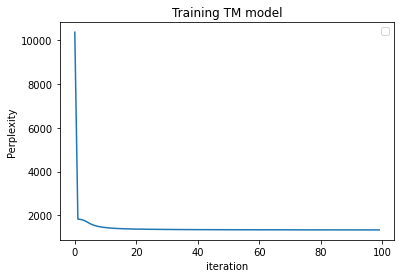

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

perplexity = model_m.score_tracker['perplexity_score'].value
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(range(ITERATIONS), perplexity )
ax.set_xlabel('iteration')  # Add an x-label to the axes.
ax.set_ylabel('Perplexity')  # Add a y-label to the axes.
ax.set_title("Training TM model")  # Add a title to the axes.
ax.legend()

In [ ]:
theta = model_m.transform(batch_vectorizer=batch_vectorizer_paralel,theta_matrix_type='dense_theta')


In [ ]:
theta

,es_649,es_65,es_650,es_651,es_652,es_653,es_654,es_656,es_657,es_658,es_659,es_661,es_662,es_663,es_668,es_67,es_672,es_673,es_675,es_679,es_680,es_682,es_684,es_685,es_686,es_689,es_690,es_691,es_693,es_695,es_697,es_698,es_699,es_701,es_702,es_703,es_704,es_705,es_706,es_709,...,ru_2815,ru_2817,ru_282,ru_2823,ru_2824,ru_2825,ru_2826,ru_2829,ru_283,ru_2832,ru_2833,ru_2835,ru_2836,ru_2837,ru_2839,ru_284,ru_2840,ru_2841,ru_2842,ru_2844,ru_2845,ru_2846,ru_2847,ru_2851,ru_2852,ru_2853,ru_2854,ru_2856,ru_2857,ru_2858,ru_2862,ru_2865,ru_2866,ru_2867,ru_2868,ru_287,ru_2869,ru_2870,ru_2871,ru_2872
topic_0,0.000558,0.009363,0.188025,0.004147,0.017133,0.030984,0.003197,0.034979,0.004442,0.569473,0.003553,0.020199,0.002771,0.006096,0.001680,0.017693,0.076819,0.116439,0.227243,0.000731,0.015971,0.002819,0.003305,0.002806,0.058152,0.011110,0.192341,0.041510,0.251494,0.012129,0.214453,0.017289,0.003952,0.011379,0.002423,0.508556,0.350497,0.620643,0.000684,0.007623,...,0.004785,0.003595,0.005001,0.095362,0.029720,0.004820,0.002407,0.004748,0.001938,0.036181,0.073581,0.082931,0.004345,0.001295,0.029049,0.000839,0.002307,0.040076,0.001314,0.040561,0.001606,0.005293,0.039117,0.002780,0.029691,0.002680,0.001396,0.007775,0.569629,0.004631,0.163952,0.004885,0.001546,0.016363,0.001816,0.087846,0.025658,0.335357,0.013208,0.003002
topic_1,0.071087,0.457188,0.083849,0.003899,0.000805,0.061626,0.052521,0.002542,0.000539,0.040529,0.167130,0.075668,0.033045,0.002949,0.017335,0.003077,0.000647,0.095682,0.006788,0.002127,0.193774,0.055588,0.000633,0.000216,0.000714,0.000996,0.045979,0.000961,0.112937,0.005411,0.048618,0.002306,0.036237,0.005645,0.009835,0.004715,0.026947,0.041187,0.028893,0.001708,...,0.001492,0.002253,0.213385,0.008586,0.005857,0.009093,0.003406,0.001424,0.011750,0.011279,0.023989,0.047029,0.003521,0.001212,0.001277,0.045739,0.433639,0.009880,0.001278,0.220337,0.001729,0.001928,0.000992,0.140705,0.192262,0.003558,0.000759,0.001857,0.011414,0.002247,0.361787,0.017516,0.007048,0.086600,0.012340,0.005623,0.005038,0.028191,0.002421,0.011123
topic_2,0.003300,0.145419,0.023192,0.000629,0.001989,0.007661,0.104281,0.003473,0.000356,0.002088,0.016884,0.044083,0.010701,0.010208,0.001042,0.003199,0.000597,0.184623,0.005924,0.026637,0.058141,0.008884,0.011385,0.001224,0.000736,0.001496,0.071001,0.001741,0.008703,0.009306,0.003028,0.000668,0.015782,0.000580,0.001146,0.005454,0.019630,0.004394,0.039242,0.009817,...,0.006262,0.003316,0.362826,0.002704,0.037885,0.004682,0.071944,0.016450,0.001930,0.338720,0.002083,0.002038,0.663245,0.003620,0.001464,0.005509,0.201075,0.009707,0.001633,0.004064,0.001283,0.006503,0.000845,0.002984,0.003835,0.014501,0.002966,0.037563,0.001160,0.001027,0.003127,0.001474,0.057638,0.016174,0.002040,0.004203,0.007514,0.005097,0.001071,0.003323
topic_3,0.058752,0.096561,0.210237,0.096566,0.016874,0.009692,0.282131,0.018506,0.080082,0.141221,0.095062,0.009592,0.181067,0.111907,0.020159,0.127439,0.096886,0.043633,0.000680,0.103395,0.064714,0.094505,0.045890,0.000297,0.010485,0.105180,0.087818,0.025932,0.212818,0.090674,0.028824,0.057139,0.182427,0.040926,0.061586,0.106190,0.172238,0.018457,0.452006,0.120762,...,0.033701,0.013618,0.118241,0.033748,0.014378,0.020945,0.041314,0.034669,0.154197,0.108589,0.076782,0.143553,0.010169,0.006189,0.017729,0.190936,0.049569,0.064464,0.031372,0.227128,0.008775,0.013059,0.031851,0.025332,0.192384,0.246084,0.021222,0.027494,0.144243,0.017012,0.066139,0.018730,0.021920,0.187415,0.002456,0.084560,0.039751,0.148759,0.006810,0.012149
topic_4,0.011959,0.001756,0.002051,0.002574,0.039961,0.024950,0.021930,0.030433,0.004271,0.006335,0.001145,0.002511,0.003814,0.437293,0.003056,0.009762,0.000599,0.007461,0.008987,0.041525,0.007340,0.009197,0.109863,0.006777,0.000839,0.032342,0.027859,0.006159,0.006393,0.763549,0.011664,0.002159,0.010743,0.012833,0.004832,0.012937,0.013502,0.003295,0.003550,0.004795,...,0.010151,0.005985,0.038992,0.002471,0.009088,0.094155,0.095996,0.096667,0.007356,0.017157,0.024680,0.

In [ ]:
theta.T

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
es_649,0.000558,0.071087,0.003300,0.058752,0.011959,0.013591,0.026210,0.016672,0.020857,0.006207,0.000697,0.001767,0.001263,0.008315,0.003587,0.599880,0.083648,0.034368,0.021682,0.000724,0.014876
es_65,0.009363,0.457188,0.145419,0.096561,0.001756,0.002072,0.040363,0.008842,0.032428,0.005023,0.018540,0.000765,0.002567,0.007615,0.012395,0.002963,0.022444,0.114297,0.010808,0.007726,0.000866
es_650,0.188025,0.083849,0.023192,0.210237,0.002051,0.004879,0.019778,0.003375,0.002371,0.013812,0.121921,0.006400,0.013807,0.031568,0.096058,0.001623,0.038587,0.042576,0.036006,0.056674,0.003211
es_651,0.004147,0.003899,0.000629,0.096566,0.002574,0.392413,0.056025,0.025130,0.262397,0.003110,0.005339,0.020768,0.007966,0.003682,0.007762,0.002174,0.084520,0.002606,0.006948,0.005299,0.006047
es_652,0.017133,0.000805,0.001989,0.016874,0.039961,0.000631,0.007428,0.228225,0.005420,0.001445,0.004548,0.120852,0.001203,0.008437,0.024649,0.001369,0.100576,0.387496,0.003482,0.025341,0.002135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ru_287,0.087846,0.005623,0.004203,0.084560,0.013425,0.082824,0.013439,0.018713,0.008915,0.003633,0.274088,0.020877,0.009872,0.020582,0.073068,0.018954,0.015877,0.228842,0.003469,0.006085,0.005104
ru_2869,0.025658,0.005038,0.007514,0.039751,0.005872,0.032159,0.032061,0.011100,0.004534,0.049267,0.026510,0.004772,0.013638,0.005257,0.053078,0.005330,0.006071,0.649266,0.005198,0.004128,0.013797
ru_2870,0.335357,0.028191,0.005097,0.148759,0.004814,0.051673,0.003257,0.108139,0.010138,0.002054,0.012645,0.001957,0.008738,0.031066,0.071838,0.005204,0.080387,0.058825,0.002732,0.010180,0.018948
ru_2871,0.013208,0.002421,0.001071,0.006810,0.001187,0.017984,0.102235,0.043117,0.013488,0.001868,0.001031,0.598847,0.001669,0.024950,0.005427,0.002746,0.021870,0.090467,0.040517,0.007913,0.001175


In [ ]:
model_m.get_phi()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
"(@spanish, tiananm)",7.657990e-07,7.139896e-07,7.492500e-07,4.158777e-07,6.831141e-07,6.085460e-07,9.458542e-07,8.701111e-07,4.013793e-05,6.632084e-07,6.177298e-07,2.219913e-06,7.172559e-07,8.510094e-07,6.441115e-07,7.159637e-07,5.610391e-07,5.003669e-07,8.974575e-06,9.508134e-07,7.964002e-07
"(@spanish, devu)",2.254866e-05,6.611701e-07,7.059465e-07,7.202593e-07,7.418498e-07,8.819954e-07,8.231190e-07,8.774547e-07,6.436456e-07,6.638055e-07,8.995641e-07,1.462525e-06,1.302933e-06,7.839718e-07,2.195358e-05,2.063958e-05,6.888467e-07,6.123253e-07,7.435607e-07,8.568126e-07,8.812631e-07
"(@spanish, resisti)",8.386985e-06,6.561470e-07,5.223321e-06,4.810721e-07,7.270778e-07,6.003270e-07,1.836009e-06,1.582845e-06,8.532316e-07,1.053866e-06,8.630446e-07,1.016983e-06,7.317643e-07,7.690581e-07,7.524470e-07,8.436762e-07,1.071387e-06,2.160681e-05,1.084568e-06,7.563239e-06,8.468273e-07
"(@spanish, geot)",8.077401e-07,7.510076e-07,1.252686e-04,3.862020e-07,1.168364e-04,5.994251e-07,7.453909e-07,9.711722e-07,1.040277e-06,5.475064e-06,6.461470e-07,6.598695e-07,7.420312e-07,7.561859e-07,7.521075e-07,7.125279e-07,5.793563e-07,5.661847e-07,7.522711e-07,8.012470e-07,8.283261e-07
"(@spanish, cosquille)",7.775257e-07,6.038940e-07,6.990072e-07,4.523692e-07,7.052157e-07,7.330588e-07,1.017309e-06,1.845236e-05,6.333908e-07,6.884444e-07,5.492234e-07,6.103868e-07,7.726792e-07,8.829540e-07,1.197360e-05,7.093914e-07,1.026436e-05,5.407568e-07,7.141460e-07,7.295178e-07,5.810966e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(@russian, самообучение)",7.582488e-06,5.551041e-06,6.376286e-06,1.217024e-05,6.087268e-06,5.018471e-06,6.225373e-06,9.211714e-06,4.851995e-06,5.258094e-06,2.681019e-05,6.561821e-06,1.609768e-05,1.880617e-05,7.274067e-06,1.453511e-05,5.220329e-06,3.493239e-06,6.161370e-06,6.835327e-06,7.914510e-06
"(@russian, сценический)",5.947521e-05,6.664985e-06,9.513335e-06,3.809696e-06,5.494801e-06,5.269737e-06,9.861060e-06,1.427014e-05,5.317247e-06,5.619255e-06,4.622698e-05,5.531234e-06,6.027809e-06,7.302674e-06,7.936563e-06,5.588076e-06,7.763556e-06,5.184781e-06,6.185400e-06,1.115880e-05,7.576642e-06
"(@russian, доход)",9.763150e-06,2.046696e-03,2.506443e-05,7.977782e-06,6.319942e-06,1.313735e-05,1.472126e-05,1.097796e-05,2.871469e-03,1.094266e-05,1.097888e-05,7.120874e-06,7.750555e-06,3.622724e-05,6.871950e-06,1.577647e-05,9.886155e-06,6.138359e-06,7.664911e-05,1.388546e-05,8.567278e-06
"(@english, methane)",1.521785e-06,1.334069e-06,4.715432e-04,7.854410e-07,4.445015e-04,1.228188e-06,1.302654e-06,1.630092e-06,1.329090e-06,2.949129e-06,1.140847e-06,1.100231e-06,3.667810e-06,1.445009e-06,1.579110e-06,1.869933e-06,1.002604e-06,8.965275e-07,1.640845e-06,1.452925e-06,2.150823e-06


In [ ]:
import statistics
from statistics import mean

In [ ]:
result_index , docs_pair = get_indexes_of_relevant_documents(model_m.transform(batch_vectorizer_mono),ru_es_parallel_docs_test)
print("RU-ES")
print(statistics.median(result_index))
print(statistics.mean(result_index))

RU-ES
3.0
52


In [ ]:
result_index , docs_pair = get_indexes_of_relevant_documents(model_m.transform(batch_vectorizer_mono),ru_en_parallel_docs_test)
print("RU-EN")
print(statistics.median(result_index))
print(statistics.mean(result_index))

RU-EN
1.0
20


In [ ]:
result_index , docs_pair = get_indexes_of_relevant_documents(model_m.transform(batch_vectorizer_mono),es_en_parallel_docs_test)
print("ES-EN")
print(statistics.median(result_index))
print(statistics.mean(result_index))

ES-EN
0.0
14


In [ ]:
theta = model_m.transform(batch_vectorizer=batch_vectorizer_paralel,theta_matrix_type='dense_theta')

In [ ]:
theta.T.sum(axis = 0, skipna = True)

topic_0     261.367462
topic_1     296.243805
topic_2     264.903564
topic_3     509.048309
topic_4     264.837463
topic_5     311.809418
topic_6     269.677979
topic_7     217.125259
topic_8     274.231354
topic_9     282.663422
topic_10    360.296967
topic_11    314.073029
topic_12    265.019623
topic_13    268.219116
topic_14    346.807404
topic_15    274.220612
topic_16    375.670471
topic_17    523.892944
topic_18    259.809113
topic_19    254.544388
topic_20    209.538757
dtype: float32

Ориентировочные фоновые темы - topc_3, topic_17, topic_16

In [ ]:
model_m.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer_fon',tau = 5, class_ids=['@spanish', '@english','@russian'], topic_names = ['topic_3,topic_17, topic_16']))
model_m.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer,fon',tau = 5, topic_names = ['topic_3,topic_17, topic_16']))

In [ ]:
ITERATIONS = 10
model_m.fit_offline(batch_vectorizer=batch_vectorizer_paralel, num_collection_passes=ITERATIONS)

Pass: 100%|██████████| 10/10 [02:18<00:00, 13.88s/it]


In [ ]:
result_index , docs_pair = get_indexes_of_relevant_documents(model_m.transform(batch_vectorizer_mono),ru_es_parallel_docs_test)
print("RU-ES")
print(statistics.median(result_index))
print(statistics.mean(result_index))

RU-ES
2.0
28


In [ ]:
result_index , docs_pair = get_indexes_of_relevant_documents(model_m.transform(batch_vectorizer_mono),ru_en_parallel_docs_test)
print("RU-EN")
print(statistics.median(result_index))
print(statistics.mean(result_index))

RU-EN
0.0
13


In [ ]:
result_index , docs_pair = get_indexes_of_relevant_documents(model_m.transform(batch_vectorizer_mono),es_en_parallel_docs_test)
print("ES-EN")
print(statistics.median(result_index))
print(statistics.mean(result_index))

ES-EN
0.0
10
